In [4]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

from sklearn.calibration import CalibratedClassifierCV

In [7]:
from matplotlib import style

style.use('bmh')

In [8]:
plt.rcParams.update({'font.size': 9})

# 18 - Heterogeneous Treatment Effects and Personalization

In [ ]:
prices_rnd = pd.read_csv('./data/ice_cream_sales_rnd.csv')
print(prices_rnd.shape)
prices_rnd.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


Remember our goal here: we need to decide when to charge more and when to charge less depending on the day specific features: `temp` `weekday` and `cost`. If that's the goal, the treatment effect heterogeneity model needs to be evaluated with respect to its usefulness in achieving this goal. We will get to that in a moment (and a lot more in the next chapter). For now, let's just split the dataset into a training and testing set.

In [ ]:
np.random.seed(123)
train, test = train_test_split(prices_rnd)

Now that we have our training data, we need to make a model which will allow us to distinguish days with high price sensitivity from days with low price sensitivity. Our approach to do that will be to simply predict price sensitivity. How exactly? First, let's consider using the following linear model

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2}X_i + e_i
$$

If we inspect the parameters of this model, we can see what our predicted sensitivity will look like.

In [ ]:
m1 = smf.ols("sales ~ price + temp + C(weekday) + cost", data=train).fit()
m1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,186.7113,1.770,105.499,0.000,183.241,190.181
C(weekday)[T.2],-25.0512,0.924,-27.114,0.000,-26.863,-23.240
C(weekday)[T.3],-24.5834,0.901,-27.282,0.000,-26.350,-22.817
C(weekday)[T.4],-24.3807,0.897,-27.195,0.000,-26.138,-22.623
C(weekday)[T.5],-24.9036,0.894,-27.850,0.000,-26.657,-23.150
C(weekday)[T.6],-24.0921,0.903,-26.693,0.000,-25.862,-22.323
C(weekday)[T.7],-0.8635,0.888,-0.972,0.331,-2.605,0.878
price,-2.7515,0.106,-25.970,0.000,-2.959,-2.544
temp,1.9848,0.060,33.117,0.000,1.867,2.102
cost,4.4718,0.528,8.462,0.000,3.436,5.508


For $m1$, the predicted price sensitivity $\widehat{\dfrac{\delta y_i}{\delta t_i}}$ will be given by $\hat{\beta_1}$, which is -2.75, in our case. This means that for each additional BRL we charge for our ice cream, we should expect sales to go down by about 3 units.

Notice how this $m1$ predicts the exact same sensitivity for everyone. Hence, it is not a very good model if we want to know on which days people are less sensitive to ice cream prices. It estimates the ATE when what we need here is the CATE. Remember that our goal is to partition the entities in such a way that we can personalize and optimize our treatment (price) for each individual partition. If every prediction is the same, there is no partitioning we can make. We are not distinguishing sensitive from non sensitive units. To correct for that, consider our second model:

$$
sales_i = \beta_0 + \beta_1 price_i + \beta_2 price_i * temp_i * + \pmb{\beta_3}X_i + e_i
$$

This second model includes an **interaction term** between price and temperature. This means that it allows the sensitivity to differ for different temperatures. What we are effectively saying here is that people are more or less sensitive to price increases depending on the temperature.

In [ ]:
m2 = smf.ols("sales ~ price*temp + C(weekday) + cost", data=train).fit()
m2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.4767,4.371,44.037,0.000,183.907,201.046
C(weekday)[T.2],-25.0805,0.924,-27.143,0.000,-26.892,-23.269
C(weekday)[T.3],-24.5871,0.901,-27.290,0.000,-26.354,-22.821
C(weekday)[T.4],-24.4225,0.897,-27.231,0.000,-26.181,-22.664
C(weekday)[T.5],-24.8953,0.894,-27.844,0.000,-26.648,-23.142
C(weekday)[T.6],-24.1269,0.903,-26.726,0.000,-25.897,-22.357
C(weekday)[T.7],-0.8581,0.888,-0.966,0.334,-2.599,0.883
price,-3.6299,0.618,-5.873,0.000,-4.842,-2.418
temp,1.7459,0.176,9.912,0.000,1.401,2.091
price:temp,0.0366,0.025,1.443,0.149,-0.013,0.086


Once we estimate the model, the predicted sensitivity is given by

$$
\widehat{\frac{\delta sales_i}{\delta price_i}} = \hat{\beta_1} + \hat{\beta_2}temp_i
$$

Notice that $\hat{\beta_2}$ is positive 0,03 and the baseline sensitivity $\beta_1$ (the sensitivity at $0C^o$) is -3.6. This means that, on average, as we increase price, sales go down, which makes sense. It also means that for each additional degree in temperature, people become less sensitive to price increases on ice cream (although not by much). For example, at $25C^o$, for each additional BRL we charge, our sales go down by 2.8 units $(-3.6 + (0.03 * 25))$. But at  $35C^o$, for each additional BRL we charge, they go down only by 2.5 units $(-3.6 + (0.03 * 35))$. This is also sort of intuitive. As the days get hotter and hotter, people are willing to pay more for ice cream.  

We can go even further. The next model includes interaction terms on all the feature space. This means that sensitivity will change with temperature, day of the week and cost.

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X_i}*price_i + \pmb{\beta_3}X_i + e_i
$$

In [ ]:
m3 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

According to the above model, the unit level sensitivity, or CATE, would be given by

$$
\frac{\delta Sales}{\delta Price} = \beta_1 + \pmb{\beta_2 X_i}
$$

Where $\beta_1$ is the price coefficient and $\pmb{\beta_2}$ is the vector for the interaction coefficients.

Finally, let's see how to actually make those sensitivity predictions. One way is to extract the sensitivity parameters from the model and use the formula above. However, we will resort to a more general approximation. Since sensitivity is nothing more than the derivative of the outcome on treatment, we can use the definition of the derivative.

$$
\frac{\delta y}{\delta t} = \dfrac{y(t+\epsilon) - y(t)}{ (t + \epsilon) - t }
$$

with $\epsilon$ going to zero. We can approximate this definition by replacing $\epsilon$ by 1.

$$
\frac{\delta y}{\delta t} \approx \hat{y}(t+1) - \hat{y}(t)
$$

where $\hat{y}$ is given by our model's predictions. In words, I'll make two predictions with my models: one passing the original data and another passing the original data but with the treatment incremented by one unit. The difference between those predictions is my CATE prediction.

Below, you can see a function for doing that. Since we've used the train set to estimate our model, we will now make predictions on the test set. First, let's use our first, ATE model, $m1$.

In [ ]:
def pred_sensitivity(m, df, t="price"):
    return df.assign(**{
        "pred_sens": m.predict(df.assign(**{t:df[t]+1})) - m.predict(df)
    })

pred_sensitivity(m1, test).head()

,temp,weekday,cost,price,sales,pred_sens
2648,18.6,7,0.5,10,185,-2.751463
2456,26.0,3,0.5,10,200,-2.751463
4557,23.7,3,0.3,8,192,-2.751463
4884,28.9,4,1.5,6,213,-2.751463
92,23.7,1,0.5,8,207,-2.751463


Making sensitivity predictions using $m1$ is not much fun. We can see that it predicts the exact same value for all the days. That's because there are no interaction terms on that model. However, if we make predictions using $m3$, it outputs a different sensitivity prediction for each day. That's because now, the sensitivity or treatment effect depends on the day specific features.

In [ ]:
pred_sens3 = pred_sensitivity(m3, test)

np.random.seed(1)
pred_sens3.sample(5)

,temp,weekday,cost,price,sales,pred_sens
4764,31.1,6,1.0,3,212,1.144309
4324,24.8,7,0.5,10,182,-9.994303
4536,25.0,2,1.5,6,205,0.279273
3466,26.0,3,1.5,3,205,0.308320
115,19.3,3,0.3,9,177,-0.349745


Notice how the predictions are numbers that go from something like -9 to something 1. Those are not predictions of the sales column, which is in the order of the hundreds. Rather, **it's a prediction of how much sales would change if we increased price by one unit**. Right off of the bet, we can see some strange numbers. For example, take a look at day 4764. It's predicting a positive sensitivity. In other words, we are predicting that sales will increase if we increase the price of ice cream. This doesn't appeal to our economic sense. It's probably the case that the model is doing some weird extrapolation on that prediction. Fortunately, you don't have to worry too much about it. Remember that our ultimate goal is to segment the units by how sensitive they are to the treatment. It's **not** to come up with the most accurate sensitivity prediction ever. For our main goal, it suffices if the sensitivity predictions orders the units according to how sensitive they are. In other words, even if positive sensitivity predictions like 1.1, or 0.5 don't make much sense, all we need is that the ordering is correct, that is, we want the units with prediction 1.1 to be less impacted by price increase than units with predictions 0.5.

Ok, we have our sensitivity or CATE model. But there is still a lurking question: how do they compare to a ML predictive model? Let's try that now. We will use a machine learning algorithm that uses price, temperature, weekday and cost as features $X$ and tries to predict ice cream sales.

In [ ]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"
ml = GradientBoostingRegressor()
ml.fit(train[X], train[y])

# make sure the model is not overfitting.
ml.score(test[X], test[y])

0.9124088322890127

This model can make predictions about how much sales we will have each day. But is it suited for what we really want? In other words, can this model distinguish between days where people are more sensitive to ice cream prices? Can it help us decide how much to charge depending on that price sensitivity?

To see which model is more useful, let's try using them for segmenting the units. For each model, we will partition the units into 2 groups. Our hope is that one group is highly responsive to price increase while the other not so much. If that is the case, we can organize our business around those groups: for the days that fall in the high responsiveness group, we better not set prices too high. For the low responsiveness group, we can increase prices without risking too much in sales.

In [ ]:
bands_df = pred_sens3.assign(
    sens_band = pd.qcut(pred_sens3["pred_sens"], 2), # create two groups based on sensitivity predictions
    pred_sales = ml.predict(pred_sens3[X]),
    pred_band = pd.qcut(ml.predict(pred_sens3[X]), 2), # create two groups based on sales predictions
)

bands_df.head()

,temp,weekday,cost,price,sales,pred_sens,sens_band,pred_sales,pred_band
2648,18.6,7,0.5,10,185,-10.301045,"(-10.597999999999999, -0.00555]",186.878081,"(161.089, 198.735]"
2456,26.0,3,0.5,10,200,0.036165,"(-0.00555, 1.389]",203.188327,"(198.735, 257.746]"
4557,23.7,3,0.3,8,192,-0.132057,"(-10.597999999999999, -0.00555]",188.800637,"(161.089, 198.735]"
4884,28.9,4,1.5,6,213,0.860663,"(-0.00555, 1.389]",210.430813,"(198.735, 257.746]"
92,23.7,1,0.5,8,207,-9.953698,"(-10.597999999999999, -0.00555]",209.044522,"(198.735, 257.746]"


Next, we need to compare which of these two segmentations is the best one. One very simple way to check how good are those partition schemas - and by good I mean useful - is to plot a regression line of prices on sales for each partition. We can achieve that easily with Seaborn's `regplot` combined with `FacetGrid`.

Below, we can see the partitions made using the sensitivity predictions. Remember that all of this is done in the test set.

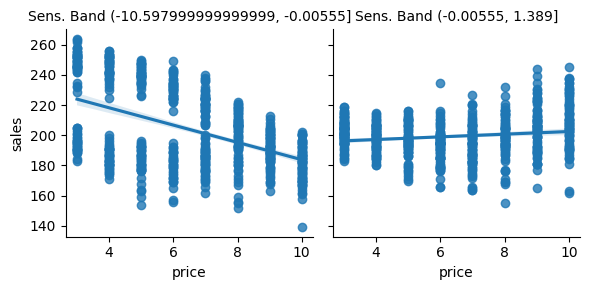

In [ ]:
g = sns.FacetGrid(bands_df, col="sens_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Sens. Band {col_name}");

As we can see, it looks like this partitioning scheme is useful. For the first partition, there is a high price sensitivity. Sales are going down by a lot as prices go up. However, for the second partition, sales remain roughly unchanged as the price goes up. In fact, it even looks like sales are going up as we increase the price, but that's probably noise.

Contrast this with the partitions made using the ML prediction model:

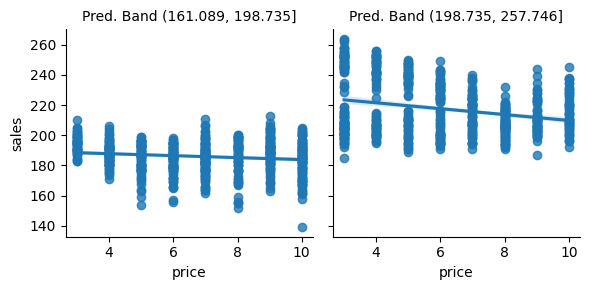

In [ ]:
g = sns.FacetGrid(bands_df, col="pred_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Pred. Band {col_name}");

I really like this plot because it conveys a very important point. As you can see, the predictive model partitions are splitting the units on the y axis. On days like those in the first partition, we don't sell a lot of ice cream, but we do sell more on days like those in the second partition. I find this amazing because the prediction model is doing exactly what it is supposed to do: it predicts sales. It can distinguish between days where there will be low versus high ice cream sales.

The only problem is that prediction is not particularly useful here. Ultimately, we want to know when we can increase prices and when we can't. But once we look at the slopes of the lines in the predictive model partitions, we see that they don't change much. In other words, both partitions, as defined by the prediction model, have about the same responsiveness to price increase. This doesn't offer us much insight into which are the days we can increase prices, since it looks like price is not affecting sales at all.



# 20 - Plug-and-Play Estimators


## Target Transformation

$
Y^*_i = Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}
$



In [ ]:
email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,1,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,1,0,1,1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0
4,35.3,2787.26,27074.44,14114.86,1,1,1,0


Our goal here is one of personalization. Let's focus on email-1. We wish to send it only to those customers who will respond better to it. In other words, we wish to estimate the conditional average treatment effect of email-1

$
E[Converted(1)_i - Converted(0)_i|X_i=x] = \tau(x)_i
$

so that we can target those customers who will have the best response to the email (higher CATE)

But first, let's break our dataset into a training and a validation set. We will estimate $\tau(x)_i$ on one set and evaluate the estimates on the other.

In [ ]:
np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


Now, we will apply the target transformation we've just learned. Since the emails were randomly assigned (although not on a 50% 50% basis), we don't need to worry about the propensity score. Rather, it is constant and equal to the treatment probability.

In [ ]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()

y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

With the transformed target, we can pick any ML regression algorithm to predict it. Lets use boosted trees here.

In [ ]:
np.random.seed(123)

cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 4
[LightGBM] [Info] Start training from score 0.070960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

This model can now estimate $\tau(x)_i$. In other words, what it outputs is $\hat{\tau}(x)_i$. For example, if we make predictions on the test set, we will see that some units have higher CATE than others. For example, customer 6958 has a CATE of 0.1, meaning the probability he or she will buy our investment product is predicted to increase by 0.1 if we send the email to this customer. In contrast, for customer 3903, the probability of buying the product is predicted to increase just 0.04.

In [ ]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,invested,em1,em2,em3,converted,cate
6958,40.9,4486.14,37320.33,12559.25,0,0,1,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,1,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,1,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,0,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,1,0,-0.009099


One of the biggest downsides of this target transformation technique is, with this target transformation, you do get a lot of simplicity, since you can just transform the target and use any ML estimator to predict heterogeneous treatment effects. The cost of it is that you get a lot of variance. That's because the transformed target is a very noisy estimate of the individual treatment effect and that variance gets transferred to your estimation. This is a huge problem if you don't have a lot of data, but it should be less of a problem in big data applications, where you are dealing with more than 1MM samples.

## The Continuous Treatment Case

Another obvious downside of the target transformation method is that it only works for discrete or binary treatments. This is something you see a lot in the causal inference literature. Most of the research is done for the binary treatment case, but you don't find a lot about continuous treatments. That bothered me a lot, because in the industry, continuous treatments are everywhere, mostly in the form of prices you need to optimize. So, even though I couldn't find anything regarding target transformations for continuous treatment, I came up with something that works in practice. Just keep in mind that I don't have a super solid econometric research around it.

To motivate it, let's go back to the ice cream sales example. There, we were tasked with the problem of estimating demand elasticity to price so that we can better set the ice cream prices to optimize our revenues. Recall that the event sample in the dataset is a day and we wish to know when people are less sensitive to price increases. Also, recall that prices are randomly assigned in this dataset, which means we don't need to worry about confounding bias.

In [ ]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


As before, let's start by separating our data into training and a testing set.

In [ ]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{(T_i - M(T_i))^2}
$



In [ ]:
y_star_cont = (train["price"] - train["price"].mean()) * (train["sales"] - train["sales"].mean())

Then, just like before, we fit a regression ML model to predict that target.


In [ ]:
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

np.random.seed(123)
cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)

cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

test_pred = test.assign(cate=cate_test_transf_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 3
[LightGBM] [Info] Start training from score -13.767533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
test_pred.sample(5)

,temp,weekday,cost,price,sales,cate
2815,15.7,4,1.5,3,187,-3.536723
257,29.4,3,1.0,3,209,8.334653
2585,24.6,6,1.0,10,197,5.628261
3260,20.2,1,0.5,4,246,-45.753226
1999,10.0,4,0.5,10,139,-7.794578


# 21 - Meta Learners


Here, we will use the same data we had before, regathing investment advertisement emails. Again, the goal here is to figure out who will respond better to the email. There is a little twist, though. This time, we will use non-random data to train the models and random data to validate them. Dealing with-non random data is a much harder task, because the meta learners will need to debias the data **AND** estimate the CATE.

In [ ]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


Our outcome variable is conversion and our treatment is email-1. Let's create variables to store those along with the features $X$ we will use to search for heterogeneity in the treatment effect.

In [ ]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

## S-Learner

The first learner we will use is the S-Learner. This is the simplest learner we can think of. We will use a single (hence the S) machine learning model $M_s$ to estimate

$
\mu(x) = E[Y| T, X]
$

To do so, we will simply include the treatment as a feature in the model that tries to predict the outcome Y.


In [ ]:
np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] Start training from score 0.200467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Then, we can make predictions under different treatment regimes. The difference in predictions between the test and control will be our CATE estimate

$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$


In [ ]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) - s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate = (s_learner.predict(test[X].assign(**{T: 1})) - s_learner.predict(test[X].assign(**{T: 0})))
) # predict under treatment - predict under control

## T-Learner

The T-learner tries to solve the problem of discarding the treatment entirely by forcing the learner to first split on it. Instead of using a single model, we will use one model per treatment variable. In the binary case, there are only two models that we need to estimate (hence the name T):

$
\mu_0(x) = E[Y| T=0, X]
$

$
\mu_1(x) = E[Y| T=1, X]
$

Then, at prediction time, we can make counterfactual predictions for each treatment and get the CATE as follows.

$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$


In [ ]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## X-Learner

The X-Learner has two stages and a propensity score model. The first one is identical to the T-learner. First, we split the samples into treated and untreated and fit a ML model for the treated and for control.

$
\hat{M}_0(X) \approx E[Y| T=0, X]
$

$
\hat{M}_1(X) \approx E[Y| T=1, X]
$

Now, things start to take a turn. For the second stage, we impute the treatment effect for the control and for the treated using the models above

$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$

$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$

Then, we fit two more models to predict those effects

$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$

$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$

 Now, we need a way to combine the two in a way that gives more weight to the correct model. Here is where the propensity score model comes to play. Let $\hat{e}(x)$ be the propensity score model, we can combine the two second stage models as follows:

$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$

Since there are very few treated units, $\hat{e}(x)$ is very small. This will give a very small weight to the wrong model $\hat{M}_{\tau 0}(X)$.

In contrast, $1-\hat{e}(x)$ is close to one, so we will give a high weight to the correct model $\hat{M}_{\tau 1}(X)$. More generally, weighted average using the propensity score will make sure we give more weight to the CATE model that was estimated where the assigned treatment was more likely. In other words, we will favor the model that was trained using more data.

In [ ]:
np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty=None)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

g.fit(train[X], train[T]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Now, we impute the treatment effect and fit the second stage models on them.

In [ ]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.107760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(max_depth=2, min_child_samples=30)

Finally, we make corrected predictions using the propensity score model.

In [ ]:
def ps_predict(df, t):
    return g.predict_proba(df[X])[:, t]

x_cate_train = (ps_predict(train, 1)*mx0.predict(train[X]) +
                ps_predict(train, 0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test, 1)*mx0.predict(test[X]) +
                                ps_predict(test, 0)*mx1.predict(test[X])))

# 22 - Debiased/Orthogonal Machine Learning



In [ ]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


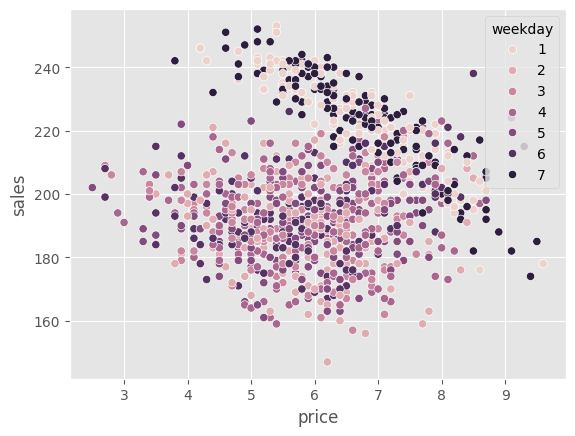

In [ ]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday");

One source of bias is very clear. As we can see, prices are much higher on the weekend (weekdays 1 and 7), but we can also have other confounders, like temperature and cost. So, if we want to do any causal inference with it, we will need to correct this bias.

## ML for Nuisance Parameters

One way we can try to remove this bias is by using a linear model to estimate the treatment effect of prices on sales while controlling for the confounders.

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 cost_i + \pmb{\beta_3} Weekday_i + e_i
$$

where $\pmb{\beta_3}$ is a vector of parameters associated with each weekday dummy.

Notice that we are only interested in the $\tau$ parameter because that's our treatment effect. We are going to call the other parameters nuisance parameters because we don't care about them. But, as it turns out, even if we don't care about them, we have to get them right, because if we don't, our treatment effect will be off. That's sort of annoying.

For instance, if we think about it, the relationship between `temp` and sales is probably not linear. First, as temperature increases, more people will go to the beach and buy ice cream, so sales will increase. But, at some point, it becomes too hot and people decide it is best to stay home. At that point, sales will drop. The relationship between `temp` and sales probably peaks somewhere and then decreases. Which means the above model is probably wrong. It should have been something like

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 cost_i + \pmb{\beta_4} Weekday_i + e_i
$$

with a quadratic term.

Thinking about how to model nuisance parameters is already boring with just a few covariates. But what if we had tens or hundreds of them? With modern datasets, this is pretty common. So, what can we do about it? The answer lies the coolest Econometric theorem ever derived.


### Frisch-Waugh-Lovell

Frisch, Waugh and Lovell were 20th century econometricians who noticed the coolest thing about linear regression. This isn't new to you, as we've talked about it in the context of regression residuals and when talking about fixed effects. But since this theorem is key to understanding Orthogonal-ML, it's very much worth recapping it.

Suppose you have a linear regression model with a set of features $X_1$ and another set of features $X_2$. You then estimate that model's parameters.

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

where $X_1$ and $X_2$ are feature matrices (one column per feature and one row per observation) and $\hat{\beta_1}$ and $\hat{\beta_2}$ are row vectors. You can get the exact same $\hat{\beta_1}$ parameter by doing the following steps

1. regress the outcome $y$ on the second set of features $\hat{y^*} = \hat{\gamma_1} X_2$
2. regress the first set of features on the second $\hat{X_1} = \hat{\gamma_2} X_2$
3. obtain the residuals $\tilde{X}_1 = X_1 - \hat{X_1}$ and $\tilde{y}_1 = y - \hat{y^*}$
4. regress the residuals of the outcome on the residuals of the features $\tilde{y} = \hat{\beta_1} \tilde{X}_1$

This is insanely cool. Here, we have a generic representation, but notice that one set of features can be just the treatment variable. This means you can estimate all the nuisance parameters separately. First, regress the outcome on the features to get outcome residuals. Then, regress the treatment on the features to get treatment residuals. Finally, regress the outcome residuals on the feature residuals. This will yield the exact same estimate as if we regress the outcome on the features and treatment at the same time.

But don't take my word for it. FWL is something that everyone interested in causal inference should do at least once. In the example below, we estimate the treatment effect by first estimating the effects of the covariates on the outcome (sales) and treatment (price).

In [ ]:
my = smf.ols("sales ~ temp + C(weekday) + cost", data=train).fit()
mt = smf.ols("price ~ temp + C(weekday) + cost", data=train).fit()

Then, with the residuals, we estimate the ATE of price on sales.

In [ ]:
smf.ols("sales_res~price_res",
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
        ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.14e-13,0.111,-3.74e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


We've estimated the ATE to -4, meaning that each unit increase in price will lower sales by 4 units.

Now, let's estimate the same parameter, but this time, we will include the treatment and the covariates in the same model.

In [ ]:
smf.ols("sales ~ price + temp + C(weekday) + cost", data=train).fit().params["price"]

np.float64(-4.000429145475419)

As you can see, they are the exact same number! This shows that estimating the treatment effect all at once or separating in the FWL steps is mathematically the same.

Another way of saying this is that the treatment effect can be derived from **regression on residuals**, where we obtain the residuals from regressing $Y$ on $X$ and regress it on the residuals of regressing $T$ on $X$. Let's say that $\sim$ is the regression operator, so we can summarise FWL theorem as follows.

$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$

which is essentially estimating the causal parameter $\tau$ in the following model

$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$

As I've said, FWL is so awesome because it allows us to separate the estimation procedure of the causal parameter from that of the nuisance parameters. But we still didn't answer our initial question, which is how can we avoid all the hassle from having to specify the correct functional form on the nuisance parameters? Or, in other words, how can we focus only on the causal parameter without having to worry about the nuisance parameters? Here is where machine learning comes to play.

### Frisch-Waugh-Lovell on Steroids

Double/Debiased ML can be seen as Frisch, Waugh and Lovell theorem on steroids. The idea is very simple: use ML models when constructing the outcome and treatment residuals:

$
Y_i - \hat{M}_y(X_i)
= \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon
$

Where $\hat{M}_y(X_i)$ is estimating $E[Y|X]$ and  $\hat{M}_t(X_i)$ is estimating  $E[T|X]$.

The idea is that ML models are super flexible, hence, they can capture interactions and non linearities when estimating the $Y$ and $T$ residuals while still maintaining a FWL style orthogonalisation. This means we don't have to make any parametric assumption about the relationship between the covariates $X$ and the outcome $Y$ nor between the covariates and the treatment in order to get the correct treatment effect. Provided we don't have unobserved confounders, we can recover the ATE with the following orthogonalisation procedure:

1. Estimate the outcome $Y$ with features $X$ using a flexible ML regression model $M_y$.
2. Estimate the treatment $T$ with features $X$ using a flexible ML regression model $M_t$.
3. Obtain the residuals $\tilde{Y} = Y - M_y(X)$ and $\tilde{T} = T - M_t(X)$
4. regress the residuals of the outcome on the residuals of the treatment $\tilde{Y} = \alpha + \tau \tilde{T}$

where $\tau$ is the causal parameter ATE, which we can estimate, for example, with OLS.

The power you gain with ML is flexibility. ML is so powerful that it can capture complicated functional forms in the nuisance relationships. But that flexibility is also troublesome, because it means we now have to take into account the possibility of overfitting.

Chernozhukov et al (2016) has a much more in depth and rigorous explanation about how overfitting can be troublesome and I definitely recommend you check it out. But here, I'll go on with a more intuition based explanation.

To see the issue, suppose that your $M_y$ model is overfitting. The result is that the residual $\tilde{Y}$ will be smaller than it should be. It also means that $M_y$ is capturing more than only the relationship between $X$ and $Y$. Part of that something more is the relationship between $T$ and $Y$, and if $M_y$ is capturing some of that, the residual regression will be biased towards zero. In other words, $M_y$ is capturing the causal relationship and not leaving it to the final residual regression.

Now to see the problem in overfitting $M_t$, notice that it will explain more of the variance in $T$ than it should. As a result, the treatment residual will have less variance than it should. If there is less variance in the treatment, the variance of the final estimator will be high. It is as if the treatment is the same for almost everyone. And if everyone has the same treatment level, it becomes very difficult to estimate what would happen under different treatment levels. As a side note, this will also happen when $T$ is a deterministic function of $X$, meaning positivity is being violated.

Those are the problems we have when using ML models, but how can we correct them? The answer lies in what we will call cross prediction and out-of-fold residuals.



We will split out data into K parts of equal size. Then, for each part k, we will estimate the ML models on all the other K-1 samples and make the residuals on the k part. Notice that these residuals are made using out-of-fold prediction. We fit the model on one part of the data, but make the predictions and residuals on another part.

so even if the model does overfit, it won't drive the residuals to zero artificially. Finally, we combine the predictions on all the K parts to estimate the final causal model $\tilde{Y} = \alpha + \tau \tilde{T}$.

OK, we've covered a lot of ground and it might be getting hard to keep up without an example. To go along with all that theory, let's go through a step by step implementation of the Double/Debiased ML. As we do so, I'll take the opportunity to explain what each step is doing.

First, let's estimate the nuisance relationship using ML models. I'll start with the treatment model $M_t$. We will use a LGBM model to predict prices from the covariates `temp`, `weekday` and `cost`. These predictions will be cross predictions, which we can get from using `sklearn`'s `cross_val_predict` function. I'm also adding the average $\hat{\mu_t}$ to the residuals just for visualization purposes.

In [ ]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res = train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5) + train[T].mean())
# add mu_t for visualization.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Notice that I'm calling the $M_t$ model the debias model. That's because the role this model is playing on the Double/Debias ML is one of debiasing the treatment. The residuals $\tilde{T} = T - M_t(X)$ can be viewed as a version of the treatment where all the confounding bias from $X$ has been removed by the model. In other words, $\tilde{T}$ is orthogonal to $X$. Intuitively, $\tilde{T}$ can no longer be explained by $X$, because it already was.

To see that, we can show the same plot we've seen earlier but now replacing price with the price residuals. Remember that, before, weekends had higher prices? Now, that bias is gone. All the weekdays have the same price residual distribution.

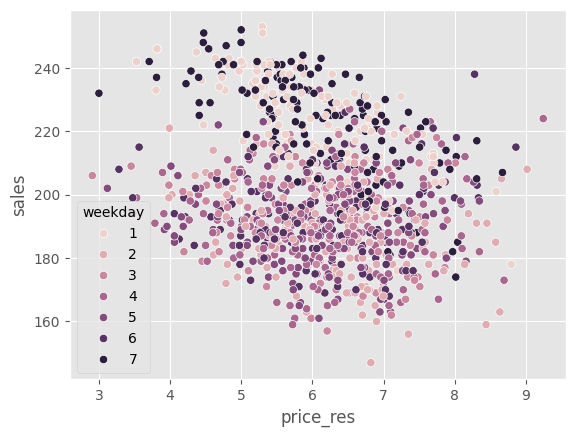

In [ ]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

The role of $M_t$ is to debias the treatment, but what about $M_y$? Its role is to remove the variance from $Y$. Hence, I'll call it the denoising model. Intuitively, $M_y$ is creating a version of the outcome where all the variance due to $X$ has been explained away. As a result, it becomes easier to do causal estimation in $\tilde{Y}$. Since it has less noise, the causal relationship becomes easier to see.

In [ ]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res = train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5)
                                                + train[y].mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 200.473000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

If we plot the same graph as before, but now replacing sales with sales residual, we can see that the variance in $Y$ is much smaller than it was before.

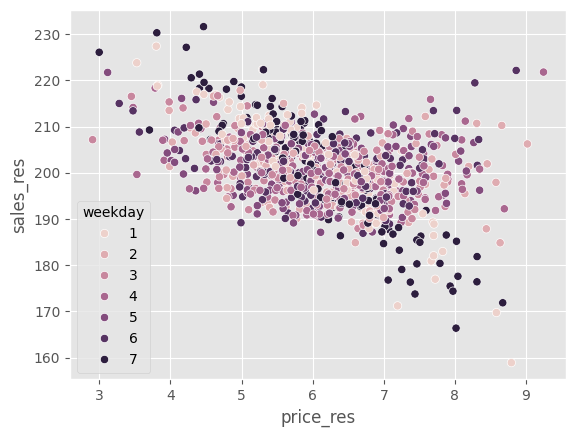

In [ ]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

It is now easy to see the negative relationship between prices and sales.

Finally, to estimate that causal relationship, we can run a regression on the residuals.

In [ ]:
final_model = smf.ols(formula="sales_res ~ price_res", data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


As we can see, when we use the residualized or orthogonalised version of sales and price, we can be very confident that the relationship between prices and sales is negative, which makes a lot of sense. As we increase prices, demand for ice cream should fall.

But if we look at the un-residualized or raw relationship between prices and sales, because of bias, we find a positive relationship. That is because, in anticipation to high sales, prices are increased.

In [ ]:
final_model = smf.ols(formula="sales ~ price", data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


### CATE Estimation with Double-ML

So far, we've seen how Double/Debiased ML allow us to focus on estimating the Average Treatment Effect (ATE), but it can also be used to estimate treatment effect heterogeneity or Conditional Average Treatment Effect (CATE). Essentially, we are now saying that the causal parameter $\tau$ changes depending on the unit's covariates.

$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$

To estimate this model, we will use the same residualised version of price and sales, but now we will interact the price residuals with the other covariates. Then, we can fit a linear CATE model.

$
\tilde{Y_i} = \alpha + \beta_1 \tilde{T_i} + \pmb{\beta}_2 \pmb{X_i} \tilde{T_i} + \epsilon_i
$

Once we've estimated such a model, to make CATE predictions, we will use the randomised test set. Since this final model is linear, we can compute the CATE mechanically:

$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

where $M$ is our final linear model

In [ ]:
final_model_cate = smf.ols(formula="sales_res ~ price_res * (temp + C(weekday) + cost)", data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                                    - final_model_cate.predict(test.assign(price_res=0)))

The Double/Debiased ML procedure with a final linear model is already very good, as we can see by the curve above. But, maybe we can do even better. As a matter of fact, this is a very general procedure that we can understand just like a meta-learner. Nie and Wager called it the R-Learner, as a way to recognise the work of Robinson (1988) and to emphasize the role of residualization.

This generalization comes from realizing that the Double/Debiased ML procedure defines a new loss function that we can minimize however we want. Next, we will see how to do that in a very similar fashion to what we've seen before when discussing target transformation method or F-learner.


## Non Parametric Double/Debiased ML

The nice thing about Double-ML is that it frees us from all the hassle of learning the nuisance parameters in a causal model. With that, we can focus all our attention to learning the causal parameter of interest, be it the ATE or the CATE. However, with the above specification, we were still using a linear model after the ML residualization, as the final causal model. In our example, this means we are assuming that price impacts sales linearly. That's probably OK for a small range of prices, but we know from microeconomic theory that that's not necessarily the case. It could be that, at low prices, a unit increase in price will lower demand by 2 units. But then, at higher prices, a unit increase in price will lower demand by just 1 unit. That's not a linear relationship.

We could leverage microeconomic theory here to speculate about the functional form of the outcome on the treatment, but maybe we can also delegate that to a ML model. In other words, let the machine learn that complicated function form. As it turns out, that's totally possible if we make a few changes to our original Double/Debiased ML algorithm.

First, we start exactly as before, orthogonalizing the treatment and the outcome with cross predictions from a ML model.

In [ ]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res = train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res = train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

So far, nothing different. Now is where things get interesting. Recall that Double/Debiased-ML models the data as follows

$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$

Where $\hat{M}_y$ and $\hat{M}_t$ are models that, respectively, predicts the outcome and treatment from the features. If we rearrange the terms above, we can isolate the error term

$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$

This is nothing short of awesome, because now we can call this a **causal loss function**. Which means that, if we minimize the square of this loss, we will be estimating expected value of $\tau(X_i)$, which is the CATE.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$

This loss is also called the **R-Loss**, since it's what the R-learner minimizes. Ok, but how do we minimize this loss function? There are multiple ways, actually, but here we will cover the simplest one. First, to declutter the technical notation, let's rewrite the loss function we had before, but using the residualized version of treatment and outcome.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$

Finally, we can do some algebraic parkour to take $\tilde{T}_i$ out of the parenthesis and isolate $\tau(X_i)$ in the square part of the loss function.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2
$$

Minimising the above loss is equivalent to minimising what is inside the parenthesis, but weighting each term by $\tilde{T}_i^2$. Minimising what's inside the parenthesis is equivalent to predicting $\frac{\tilde{Y}_i}{\tilde{T}_i}$. This is what's called the weight trick to get the non-parametric causal loss. Notice how similar this is to the target transformation idea we saw earlier. This is, indeed, a target transformation, but with the extra weighting trick.

To summarise before we go to the code, now that we have the nuisance models and residualised versions of treatment and outcome, we will
1. Create weights $\tilde{T}_i^2$
2. Create a target $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$
3. Use any prediction method to predict the target (2) while using the weights (1).

And here is the code. As you will see, it is incredibly simple.




In [ ]:
model_final = LGBMRegressor(max_depth=3)

# create the weights
w = train_pred["price_res"] ** 2

# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])

# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 3
[LightGBM] [Info] Start training from score -3.922826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

The above ML model, even though it is an off-the-shelf predictive model, is estimating the CATE. That's the power of the non-parametric Double-ML. Before, we were using a linear regression as the final model for the CATE estimation. Now, since we defined a generic loss, we can use any predictive model at our disposal as the final model.

Let's now use the test set to compare this non-parametric version with the linear version we had before.

First, we estimate the individual treatment effect.

In [ ]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

Not a huge improvement here, but it's something. Plus, not having to specify the functional form of the treatment function is already a huge benefit.


### What is Non-Parametric About?

Before we move on, I just wanted to highlight a common misconception. When we think about using a non-parametric Double-ML model to estimate the CATE, it looks like we will get a nonlinear treatment effect. For instance, let's assume a very simple data generating process (DGP) where discont affects sales non-linearly, but through a square root function.

$
Sales_i = 20 + 10*\sqrt{Discount_i} + e_i
$

The treatment effect is given by the derivative of this Sales function with respect to the treatment.

$
\dfrac{\partial Sales_i}{\partial Discount_i} = \dfrac{10}{2\sqrt{Discount_i}}
$

As we can see, the treatment effect is **not** linear. It actually gets weaker as the treatment increases. This makes a lot of sense for this DGP. At first, a little bit of discount increases sales by a lot. But, as we give too much discount, an extra unit of discount will affect sales less and less, because people won't want to buy to infinity. Hence, the discount is only effective up until they point they get satiated.

The question then is, can the non-parametric ML capture this saturating behavior in the treatment effect? Can it extrapolate from a small discount level that, if the discount were higher, the treatment effect would be lower? The answer is... sort of. To better understand that, let's generate data like in the above DGP.

In [ ]:
np.random.seed(321)
n = 5000
discount = np.random.gamma(2, 10, n).reshape(-1, 1)
discount.sort(axis=0)
sales = np.random.normal(20+10*np.sqrt(discount), 1)

If we plot this DGP, we can see the square root relationship between these variables.

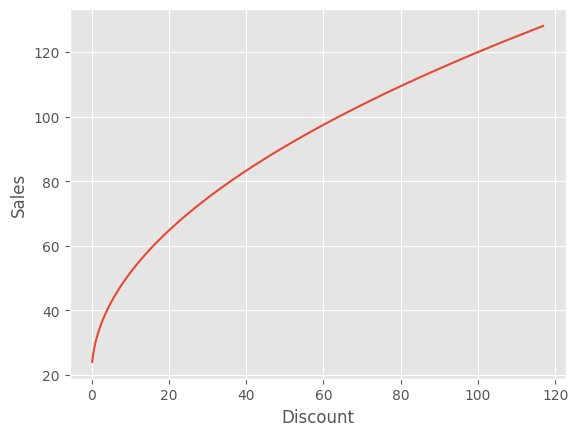

In [ ]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel('Sales')
plt.xlabel('Discount');

Now, let's apply the Non-Parametric Double/Debias ML to this data.

In [ ]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# orthogonalising step
discount_res = discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res = sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = discount_res ** 2
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1, 1), y=y_star.ravel(), sample_weight=w.ravel());

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 0
[LightGBM] [Info] Start training from score 23.675958
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

With the above model, we can get the CATE estimate. The issue here is that the CATE is not linear. As the treatment increases, the CATE should decrease. The question we are trying to answer is if the non-parametric model can capture that non linearity.

To answer that properly, let's remember what is the underlying assumption that the Double/Debiased ML makes about the data generating process. These assumptions can be seen in the equation we've laid down before.

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$

In words, it says that the residualized outcome is equal to the residualized treatment multiplied by the conditional treatment effect. This mean that the **treatment impacts the outcome linearly**. There is no non-linearity here. The above model says that the outcome will increase by a fixed amount $\tau(X_i) $ if we increase the treatment from 1 to 10 or from 100 to 110. It's a simple multiplication.

So, does this mean that the non-parametric model can't capture the non-linearity of the treatment effect? Again, not really... Rather, what is happening is that Double/ML **finds the locally linear approximation to the non-linear CATE**. In other words, it finds the derivative of the outcome with respect to the treatment at that treatment level or around the treatment. This is equivalent to finding the slopes of the lines that are tangential to the outcome function at the treatment point.



This mean that, yes, Non-Parametric Double-ML will figure out that the treatment effect will be smaller as we increase the treatment. But, no, it won't find the non-linear treatment effect, but rather the local linear treatment effect. We can even plot those linear approximations against the ground true non-linear causal effect and indeed, they are good approximations.

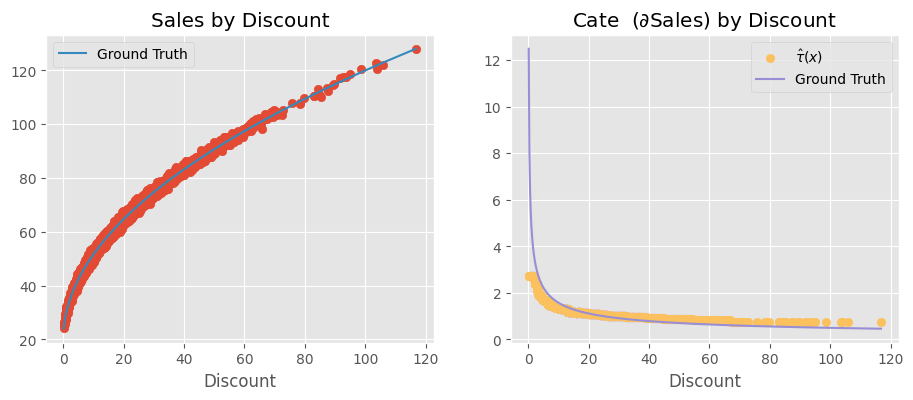

In [ ]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel('Discount')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("Cate  ($\partial$Sales) by Discount")
plt.xlabel('Discount')
plt.legend();

This might sound like technicalities, but it has very practical consequences. For example, let's say you find a treatment effect of 2 for a customer in the example above, meaning that if you increase the discount by 1 unit, your sales to that customer will increase by 2 units. You might look at that and think: "Great! I'll give a lot of discounts to this unit! After all, for every 1 unit in discount, I'll get 2 in sales". However, that's the wrong conclusion. The treatment effect is 2 only at that discount level. As soon as you increase the discount, the effect will fall. For example, say this hypothetical customer got only 5 in discount, which is why her treatment effect is so high. Say you see that huge treatment effect and use it to justify giving 20 in discount to that customer. But as you do so, the effect might go from 2 to something like 0.5. And a 20 discount that made sense at a treatment effect of 2 might no longer be profitable at a treatment effect of 0.5.

This means you have to be extra careful when extrapolating a nonlinear treatment effect to a new treatment level. If you are not, you might end up making very unprofitable decisions. Another way to put is is that, when treatment effect is not linear, even non-parametric Double/Debiased-ML will **struggle to make counterfactuals outcome predictions**. It will try to linearly extrapolate the treatment effect (TE) from a low treatment level to a high treatment level or the other way around. And, due to the non linearity, that extrapolation will likely be off.

To solve that, there is a final idea. Keep in mind that this idea is much less scientific than the things we've seen before. It boils down to using a S-learner after applying the orthogonalization procedure, but I'm getting ahead of myself. Let's look at that next.


## Non-Scientific Double/Debiased ML

The final idea we will try is a fundamental shift in mentality. We will no longer try to estimate the linear approximation to the CATE. Instead, we will make counterfactual predictions.


The CATE is the slope of the outcome function at the data point. It is how much we expect the outcome to change if we increase the treatment by a very small amount. More technically, it's the derivative at the point. Counterfactual predictions, on the other hand, are an attempt to recreate the entire outcome curve from a single datapoint. We will predict what the outcome would be if the treatment were at some other level than the one it currently takes, hence the counterfactual.

If we manage to do so, we will be able to simulate different treatments for a unit and predict how it would respond under those different treatment levels. This is very risky business, because we will be extrapolating an entire curve from a single point. Also, although I've used this technique in practice a lot, I've never found any scientific article showing how or why it works. That's why I call it the Non-Scientific Double-ML. Simply put: beware!

Here is how this will go down. First, let's start with the traditional Double/Debiased-ML formulation, where we have the residualized version of the treatment and outcome.

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$

Now, I'll move the treatment inside the treatment effect function. This allows the treatment effect to be non linear, that is to change with the treatment itself.

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$

This is dangerous business, because I have no idea how this treatment functions. For all we know, it could be some weird non-linear function. But, fortunately, we know how to estimate weird functions with Machine Learning. So, that's what we will do. Simply speaking, we will fit a ML model to predict the residualised outcome $\tilde{Y}$ from the residualized treatment $\tilde{T}$ together with the features $X$. The residualisation is important to remove bias and noise so that this final ML can focus on learning only the treatment effect and how the covariates $X$ impact that treatment effect.

Then, once we have this model, we will make 2 step counterfactual predictions. First we will have to make a prediction for the treatment in order to get $\tilde{T}$, then, we will feed that prediction, along with the features, in our final model $\hat{\tau}(X_i, \tilde{T}_i)$.

Since we will have to make $\tilde{T}$, we first need to implement our own version of the `cross_prediction` function. This function will return not only the cross prediction, but also the models used to make those predictions.

In [ ]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]

    return cv_pred, models

Now that we have our own cross prediction function that also gives us the models, we can proceed with the orthogonalisation step.

In [ ]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 200.473000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

After the orthogonalisation, we will throw $\tilde{T}$ along with $X$ to a ML model that tries to precit $\tilde{Y}$. I'm using a LGBM model here, but you can pick any ML model. One cool thing about LGBM is that I can set monotonic constraints to it. Knowing what we know about prices, sales should decrease as price increases. We can take that into account and constrain our LGBM model **to not increase** it's predictions as prices increase.

In [ ]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]

model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 4
[LightGBM] [Info] Start training from score 0.010779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Now is where things get a little weird. If we think about it, this final ML model is estimating the following $\tau$ treatment function

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$

but there isn't a clear way to extract the treatment effect from this function. So,  rather than extracting a treatment effect, we will input the counterfactual predictions, just like I've shown in the previous image. We will simulate different price levels for each unit and use our Double-ML model to predict what would be the sales we would see under those different price levels.

To achieve that, we will 1) cross join the test set with a price table that contains all simulated prices. The end result will be as follows

In [ ]:
pred_test = (test.rename(columns={"price":"factual_price"})
                          .assign(jk=1)
                          .reset_index() # create day ID
                          .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
                          .drop(columns=["jk"]))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price
0,0,25.8,1,0.3,7,230,3.000
1,0,25.8,1,0.3,7,230,3.875
2,0,25.8,1,0.3,7,230,4.750
3,0,25.8,1,0.3,7,230,5.625
4,0,25.8,1,0.3,7,230,6.500
5,0,25.8,1,0.3,7,230,7.375
6,0,25.8,1,0.3,7,230,8.250
7,0,25.8,1,0.3,7,230,9.125
8,0,25.8,1,0.3,7,230,10.000


Notice that we are showing only the day in index 1, so only a single unit. On that day (unit), the actual or factual price or treatment was 7. But we've simulated different counterfactual treatments, from 3 to 10. Now, we will feed all those counterfactual prices to our causal model, which will make counterfactual sales predictions based on those simulated prices.

Since our model has the following format

$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$

Before making the counterfactual predictions, we need to get $\tilde{T}_i$, that is, the price residuals. We will get those residuals by first, making predictions will all our treatment models (remember that we've used a 5 fold cross prediction in the training step), then we will average the predictions from the five models into a single prediction and finally subtract the counterfactual price we've generated earlier from the predicted price using this ensemble of models.

In [ ]:
def ensemble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensemble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,24.302849
1,0,25.8,1,0.3,7,230,3.875,20.862833
2,0,25.8,1,0.3,7,230,4.750,16.093630
3,0,25.8,1,0.3,7,230,5.625,6.274595
4,0,25.8,1,0.3,7,230,6.500,-1.624625
5,0,25.8,1,0.3,7,230,7.375,-10.939867
6,0,25.8,1,0.3,7,230,8.250,-21.655858
7,0,25.8,1,0.3,7,230,9.125,-25.319174
8,0,25.8,1,0.3,7,230,10.000,-25.319174


As you can see, we now have a sales prediction for every simulated price. The lower the price, the higher the sales. One interesting thing is that these predictions are off in their level. For instance, they go from about 24 to about -24. That's because the model is predicting the residualized outcome, which is roughly mean zero. This is fine if all you want is to get the slope of the sales curve, which is the price treatment effect. Also, if you want to fix the prediction levels, all you have to do is add the predictions from the denoising model $M_y$.

In [ ]:
y_hat_test = ensemble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test + model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,254.208352
1,0,25.8,1,0.3,7,230,3.875,250.768336
2,0,25.8,1,0.3,7,230,4.750,245.999133
3,0,25.8,1,0.3,7,230,5.625,236.180099
4,0,25.8,1,0.3,7,230,6.500,228.280878
5,0,25.8,1,0.3,7,230,7.375,218.965636
6,0,25.8,1,0.3,7,230,8.250,208.249645
7,0,25.8,1,0.3,7,230,9.125,204.586329
8,0,25.8,1,0.3,7,230,10.000,204.586329


We can also plot the unit level sales curve. Let's sample ten units and see how they would behave under different prices.

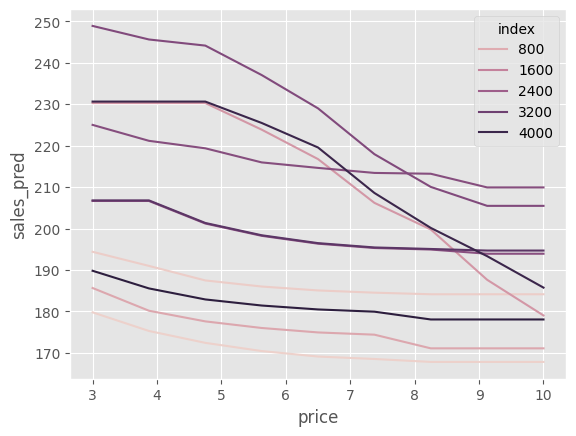

In [ ]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

It is interesting to see that some units are very sensitive to price increases. In some cases, we expect sales to drop from 250 to almost 200 as we increase the price from 3 to 10. On the other hand, some units are very inelastic to price: as we increase prices from 3 to 10, we expect the sales to go from about 195 to about 185.

It's hard to see these differences in price sensitivity, so what I like to do is to make all the curves start from the same point (the average sales here). This will make it easier to see that some units have a sharp drop in sales as we increase prices, while others not so much.

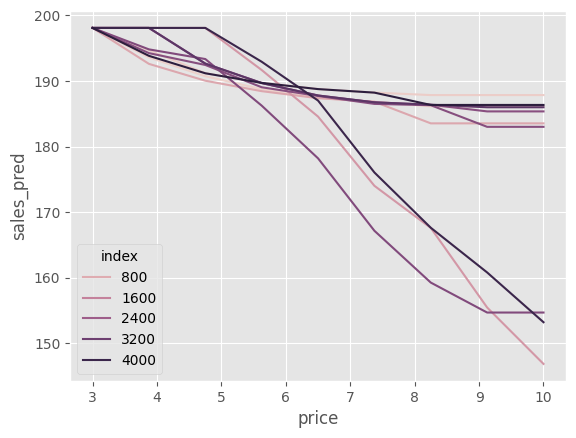

In [ ]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

### More Econometrics May be Needed!

I want to end this section on the non-scientific Double-ML with a word of caution. I didn't call this approach non scientific for nothing. It is sort of a hack to get non linear counterfactual predictions. And since it's a hack, I feel it is worth talking about its potential downsides.

First and foremost, it has the same problems all ML techniques have when applied naively to causal inference: bias. Since the final model is a regularized ML model, this regularization can bias the causal estimate to zero.

The second problem has to do with the ML algorithm you choose. Here, we choose boosted trees. Trees are not very good at making smooth predictions. As a consequence, we can have discontinuities in the prediction curve. You can see that in the plots above: a stepwise behavior here and there. Also, trees are not very good at extrapolating, so this model might output weird predictions for prices never seen before.

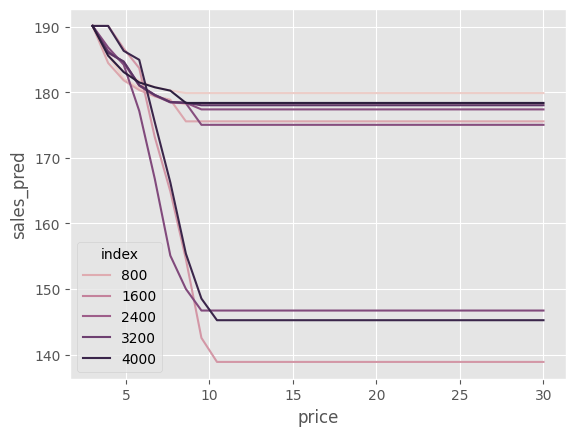

In [ ]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensemble_pred(pred_test, models_t, X)

y_hat_test = ensemble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

All this to say that this approach is highly dependent on the final ML model. If you regularize it too much, you will bias your causal estimates to zero. If you use this or that ML algorithm, you carry all its limitations to your final counterfactual predictions. Still, if you think this approach is worth a try, by all means give it a shot! Just don't forget the downsides I've outlined here.

## Key Ideas

Double/Debiased/Orthogonal ML is a way to delegate estimating nuisance parameters which allows us to focus our attention on the causal parameter of interest. It first employes a two step orthogonalisation procedure:

1. Fit a model $M_t(X)$ to predict the treatment from the covariates X and get out of fold residuals $\tilde{t} = t - M_t(X)$. We called this the debiasing model because the residuals $\tilde{t}$ are, by definition, orthogonal to the features used to construct it.

2. Fit a model $M_y(X)$ to predict the outcome from the covariates X and get out of fold residuals $\tilde{y} = y - M_y(X)$. We called this the denoising model because the residual $\tilde{y}$ can be seen as a version of the outcome where all the variance from the features got explained away.

Once we have those residuals, provided there are no unmeasured confounders, we can regress $\tilde{y}$ on $\tilde{t}$ for a linear approximation to the ATE. We can also interact $\tilde{t}$ with the covariates to estimate the CATE or use a weighting trick to allow for any generic ML model as our final CATE model.

Finally, I've argued that the orthogonalization steps is a general tool to facilitate causal learning. In that spirit, we've tried to feed the treatment and outcome residuals to a S-learner style ML algorithm. With that, we managed to get counterfactual predictions from simulated treatments. Indeed orthogonal ML serves as a pre-processing step in many causal inference applications.



# 23 - Debiasing with Orthogonalization

Let's take our price data once again. But now, we will only take the sample where prices where **not** randomly assigned. Once again, we separate them into a training and a test set. Since we will use the test set to evaluate our causal model, let's see how we can use orthogonalization to debias it.

In [9]:
prices = pd.read_csv("./data/ice_cream_sales.csv")

train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

If we show the correlations on the test set, we can see that price is positively correlated with sales, meaning that sales should go up as we increase prices. This is obviously nonsense. People don't buy more if ice cream is expensive. We probably have some sort of bias here.

In [10]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,0.002270,-0.015989,-0.019599,0.381941
weekday,0.002270,1.000000,0.011561,0.027958,0.016709
cost,-0.015989,0.011561,1.000000,0.389224,-0.002876
price,-0.019599,0.027958,0.389224,1.000000,0.082249
sales,0.381941,0.016709,-0.002876,0.082249,1.000000


If we plot our data, we can see why this is happening. Weekends (Saturday and Sunday) have higher price but also higher sales. We can see that this is the case because the weekend cloud of points seems to be to the upper right part of the plot.

Weekend is probably playing an important role in the bias here. On the weekends, there are more ice cream sales because there is more demand. In response to that demand, prices go up. So it is not that the increase in price causes sales to go up. It is just that both sales and prices are high on weekends.

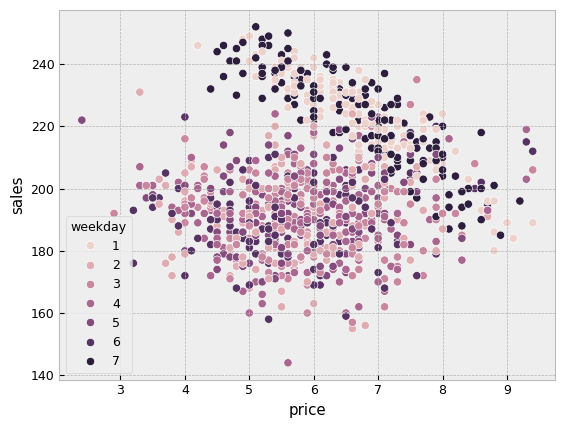

In [12]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

To debias this dataset we will need two models. The first model, let's call it $M_t(X)$, predicts the treatment (price, in our case) using the confounders. It's the one of the stages we've seen above, on the Frisch–Waugh–Lovell theorem.

In [13]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

Once we have this model, we will construct the residuals

$$
\hat{t}_i = t_i - M_t(X_i)
$$

You can think of this residual as a version of the treatment that is unbiased or, better yet, that is impossible to predict from the confounders $X$. Since the confounders were already used to predict $t$, the residual is by definition, unpredictable with $X$. Another way of saying this is that the bias has been explained away by the model $M_t(X_i)$, producing $\hat{t}_i$ which is as good as randomly assigned. Of course this only works if we have in $X$ all the confounders that cause both $T$ and $Y$.

We can also plot this data to see what it looks like.

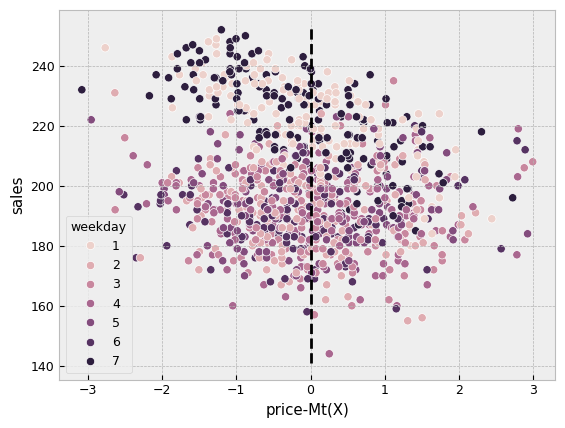

In [14]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles="--", color="black");

We can see that the weekends are no longer to the upper right corner. They got pushed to the center. Moreover, we can no longer differentiate between different price levels (the treatment) using the weekdays. We can say that the residual $price-M_t(X)$, plotted on the x-axis, is a "random" or debiased version of the original treatment.

This alone is sufficient to debias the dataset. This new treatment we've created is as good as randomly assigned. But we can still do one other thing to make the debiased dataset even better. Namely, we can also construct residuals for the outcome.

$$
\hat{y}_i = y_i - M_y(X_i)
$$

This is another stage from the Frisch–Waugh–Lovell theorem. It doesn't make the set less biased, but it makes it easier to estimate the elasticity by reducing the variance in $y$. Once again, you can think about $\hat{y}_i$ as a version of $y_i$ that is unpredictable from $X$ or that had all its variances due to $X$ explained away. Think about it. We've already used $X$ to predict $y$ with $M_y(X_i)$. And $\hat{y}_i$ is the error of this prediction. So, by definition, it's not possible to predict it from $X$. All the information in $X$ to predict $y$ has already been used. If that is the case, the only thing left to explain $\hat{y}_i$ is something we didn't used to construct it (not included in $X$), which is only the treatment (again, assuming no unmeasured confounders).

In [15]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

Once we do both transformations, not only does weekdays not predict the price residuals, but it also can't predict the residual of sales $\hat{y}$. The only thing left to predict these residuals is the treatment. Also, notice something interesting. In the plot above, it was hard to know the direction of the price elasticity. It looked like sales decreased as prices went up, but there was such a large variance in sales that it was hard to say that for sure.

Now, when we plot the two residuals, it becomes much clear that sales indeed causes prices to go down.

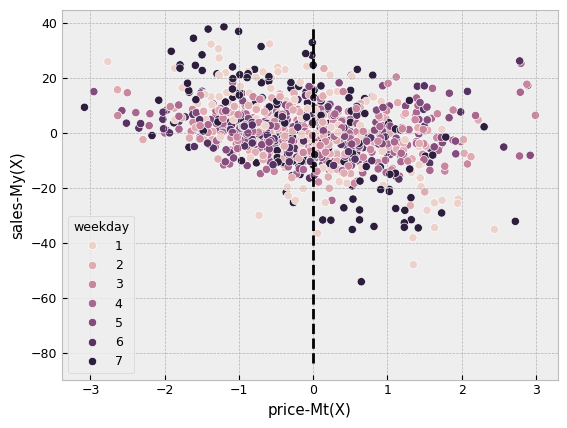

In [17]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles="--", color="black");

One small disadvantage of this debiased data is that the residuals have been shifted to a different scale. As a result, it's hard to interpret what they mean (what is a price residual of -3?). Still, I think this is a small price to pay for the convenience of building random data from data that was not initially random.

To summarize, by predicting the treatment, we've constructed $\hat{t}$ which works as an unbiased version of the treatment; by predicting the outcome, we've constructed $\hat{y}$ which is a version of the outcome that can only be further explained if we use the treatment. This data, where we replace $y$ by $\hat{y}$ and $t$ by $\hat{t}$ is the debiased data we wanted. We can use it to evaluate our causal model just like we deed previously using random data.

To see this, let's once again build a causal model for price elasticity using the training data.

In [18]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

Then, we'll make elasticity predictions on the debiased test set.

In [19]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
                - model.predict(price_df)) / h

debiased_test_pred = debiased_test.assign(**{
    "m3_pred" : predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
1471,18.9,1,0.3,5.9,237,-0.381640,24.316774,-10.314084
4635,21.6,7,1.0,7.8,206,0.807246,-10.823140,-12.726910
4416,23.6,3,1.5,8.1,198,1.580704,7.566735,-1.116164
3615,30.8,3,0.3,4.9,202,-0.405109,-2.416573,-1.841211
4952,26.8,7,0.5,6.5,219,0.019544,-7.823017,-13.934414


Now, when it comes to plotting the cumulative elasticity, we still order the dataset by the predictive elasticity, but now we use the debiased versions of the treatment and outcome to get this elasticity. This is equivalent to estimating $\beta_1$ in the following regression model

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

where the residuals are like we've described before.

## Orthogonalization with Machine Learning

In a 2016 paper, Victor Chernozhukov *et all* showed that you can also do orthogonalization with machine learning models. This is obviously very recent science and we still have much to discover on what we can and can't do with ML models. Still, it's a very interesting idea to know about.

The nuts and bolts are pretty much the same to what we've already covered. The only difference is that now, we use machine learning models for the debiasing.

$$
\begin{align}
\hat{y}_i &= y_i - M_y(X_i) \\
\hat{t}_i &= t_i - M_t(X_i)
\end{align}
$$

There is a catch, though. As we know very well, machine learning models are so powerful that they can fit the data perfectly, or rather, overfit. Just by looking at the equations above, we can know what will happen in that case. If $M_y$ somehow overfits, the residuals will all be very close to zero. If that happens, it will be hard to find how $t$ affects it. Similarly, if $M_t$ somehow overfits, its residuals will also be close to zero. Hence, there won't be variation in the treatment residual to see how it can impact the outcome.

To account for that, we need to do sample splitting. That is, we estimate the model with one part of the dataset and we make predictions in the other part. The simplest way to do this is to split the test sample in half, make two models  in such a way that each one is estimated in one half of the dataset and makes predictions in the other half.

A slightly more elegant implementation uses K-fold cross validation. The advantage being that we can train all the models on a sample which is bigger than half the test set.

Fortunately, this sort of cross prediction is very easy to implement using Sklearn's `cross_val_predict` function.

In [21]:
X = ["cost", "weekday", "temp"]
t = "price"
y = "sales"

folds = 5

np.random.seed(123)
m_t = RandomForestRegressor(n_estimators=100)
t_res = test[t] - cross_val_predict(m_t, test[X], test[t], cv=folds)

m_y = RandomForestRegressor(n_estimators=100)
y_res = test[y] - cross_val_predict(m_y, test[X], test[y], cv=folds)

Now that we have the residuals, let's store them as columns on a new dataset.

In [22]:
ml_debiased_test = test.assign(**{
    "sales-ML_y(X)":y_res,
    "price-ML_t(X)":t_res,
})
ml_debiased_test.head()

,temp,weekday,cost,price,sales,sales-ML_y(X),price-ML_t(X)
1471,18.9,1,0.3,5.9,237,-2.306667,0.484500
4635,21.6,7,1.0,7.8,206,-15.202833,1.037667
4416,23.6,3,1.5,8.1,198,-1.473857,2.067988
3615,30.8,3,0.3,4.9,202,-8.296667,-2.100167
4952,26.8,7,0.5,6.5,219,-7.100000,-0.523000


Finally, we can plot the debiased dataset.

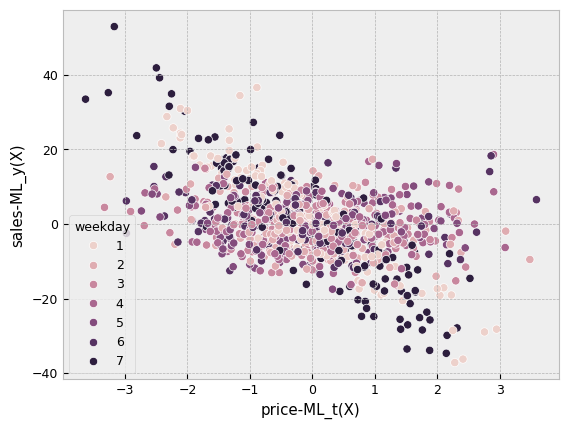

In [24]:
np.random.seed(123)
sns.scatterplot(data=ml_debiased_test.sample(1000),
                x="price-ML_t(X)", y="sales-ML_y(X)", hue="weekday");

Once again, we've uncovered a negative price elasticity on sales. Actually, the plot is incredibly similar to the one we've got when using simple linear regression. But that's probably because this is a very simple dataset. The advantages of machine learning orthogonalization is that it can estimate more complicated functions. It can learn interactions and non linearities in a way that it's hard to encode into linear regression. Also, there is the advantage that some machine learning models (those bases on decision trees) are much simpler to run than linear regression. They can handle categorical data, outliers and even missing data, stuff that would require some attention if you are just using linear regression.

Finally, before we close, I just need to cover one final common mistake that data scientists often make when they are introduced to this idea (been there, done that). If the treatment or the outcome is binary, one might think it is better to replace the machine learning regression models for their classification versions. However, this does not work. The theory of orthogonalization only functions under regression models, similarly with what we've seen a long time ago when talking about Instrumental Variables. To be honest, it is not that the model will fail miserably if you replace regression by classification, but I would advise against it. If the theory doesn't justify it, why run the risk?

## Key Ideas

We've started the chapter by highlighting the necessity of random treatment assignment in order for our causal evaluation methods to work. This poses a problem in the case where random data is not available. To be clear, the safest solution in this case is to go and do some experiments in order to get random data. If that is out of the question, only then, we can rely on a clever alternative: transform our data to look as if the treatment has been randomly assigned.

Here, we've covered how to do that using the principles of orthogonalization. First, we've built a model that uses our features $X$ to predict the treatment $t$ and get it's residuals. The idea being that the treatment residuals is, by definition, independent of the features used to construct it. In other words, the treatment residuals are orthogonal to the features. We can see these residuals as a version of the treatment where all the confounding bias due to $X$ has been removed.

That alone is enough to make our data look as good as random. But we can go one step further. We can build a model that predicts the outcome $y$ using the features $X$ but not the treatment and also get its residuals. Again, the intuition is very similar. These outcome residuals is a version of the outcome where all the variance due to the features has been explained away. That will hopefully explay a lot of the variance, making it easier to see the treatment effect.

Here we are using orthogonalization with the goal of debiasing our data for model evaluation. However, this technique is also used for other purposes. Namely, lot's of causal inference models use orthogonalization as a first pre-processing step to ease the task of the causal inference model. We can say that orthogonalization makes the foundation of many modern causal inference algorithms.



# 24 - Debiasing with Propensity Score


Previously, we saw how to go from a biased dataset to one where the treatment looked as good as randomly assigned. We used orthogonalization for that. That technique was based on predicting the treatment and the outcome and then replacing both with their predictions' residuals.

$
t^* = t - M_t(X)
$

$
y^* = y - M_y(X)
$

That alone is a powerful technique. It works both when the treatment is continuous or binary. Now, we'll take a look at another method which is based on the propensity score. Since the propensity score is best defined when the treatment is binary or categorical, this debiasing technique will also work only for categorical  or binary treatments. Still, in some situations, it can be more reliable than orthogonalization and it is very much worth learning.

But first, we need to change context a little bit. We were talking about ice cream prices, which is a continuous treatment. Now, we will look into marketing emails, a binary treatment. And just as a side note, it is totally fair play to discretize a continuous treatment into buckets so it looks categorial (for example, you can take price, which is continuous, and discretize it in bins of R$ 2.00 like [2.00, 4.00, 6.00, 8.00]). Back to the emails now.

The situation goes like this. You work at a financial company (I'm not very creative with my examples, sorry) that supplies, not surprisingly, financial products such as life insurance, savings account, investment account and so on. The company is coming up with a new financial consulting service and wants to market it to its customers. To do so, the marketing team tried out three different emails: `em1`, `em2` and `em3`.

Because the marketing team is very well educated in statistics and experimental design, they don't simply send the email to everyone and see what happend. Instead, they design an experiment where each customer has a probability of receiving the email. This probability is based on their business intuition to who will be more responsive to the email. For example, `em1` is targeted to a mass market audience, that don't invest much and that don't have a high income. These people will have a higher probability of receiving `em1`. Finally, after having defined that probability, we randomize the assignment so that customers receive the email according to their assigned probabilities.



As a side note, this is the best way I know of that uses business expertise to target an audience while still allowing you to make valid inference about how effective the marketing strategy is. The marketing team not only assigned the email according to this probability function, but they actually stored each customers' probability, which will be very handy later on.

Here is what the data from this experiment looks like. We have data on four customer attributes: `age`, `income`, how much they have on life `insurance` and how much they have `invested`. These are the attributes which the marketing team used to assign the probability of receiving each email. Those probabilities are stored in columns `em1_ps`, `em2_ps` and `em3_ps`. Then, we have information on whether the customer actually received the email on columns `em1`, `em2` and `em3`. These are our treatment variables. Finally, we have the outcome, `converted`, flags if the customer contracted the financial advisory service.

In [25]:
email = pd.read_csv("./data/invest_email.csv")
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


As we can see, there are customers with very low probability of receiving `em1`. This is the case of customer 2, which has a probability of only 0.062. Also notice that this customer did not receive `em1`. This is not surprising, given that he had a very low probability of receiving this email.

Now, contrast this with the following customers. All of them had a very high chance of getting `em1`, but none of them did.

In [26]:
email.query("em1==0").query("em1_ps>0.9")

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
2438,48.0,538.02,26276.38,1582.82,0.913562,0.008951,0.999208,0,0,1,1
2692,44.2,545.62,2377.01,743.40,0.901065,0.004204,0.999047,0,0,1,0
3152,44.6,541.42,13272.96,1455.92,0.907929,0.008233,0.999136,0,0,1,1
4175,38.0,543.20,16787.28,1302.20,0.905007,0.007364,0.000000,0,0,0,1


## Inverse Probability of Treatment Weighting





Just to recap the idea behind propensity score debiasing (we've already seen it when we discussed propensity score), we are very interested in customers like the ones above. They look a lot like the ones that get `em1`, after all they had a high probability of getting that email. However, they didn't get it. This makes them awesome candidates to estimate the counterfactual outcome $Y_0|em1=1$.

Propensity score debiasing works by encoding this intuitive importance we want to give to customers that look like the treated, but didn't get the treatment. It will also assign a high importance for those that look like the untreated, but got the treatment. The idea is pretty simple: just **weight every unit by the inverse probability of the treatment they got**. So, if a unit got the treatment, weigh it by $1/P(treatment=1)$. If a unit did not get the treatment, weigh it by $1/P(treatment=0)$ or $1/P(control)$. In the case of binary treatment, this is simply

$$
W_i = \dfrac{T}{P(T=1|X)} + \dfrac{1-T}{1-P(T=1|X)}
$$

For multiple treatments, we can generalize it to

$$
W_i = \sum^K_{k=0} \dfrac{\mathcal{1}_{K=k} }{P(T=k|X)}
$$

Now that we had an idea about how to use the propensity score to do debiasing, let's check how this works in practice. But first, let's see what happens when we don't debias our dataset.

Like I've said before, the treatment is confounded by the customer's characteristics: age, income, how much they have on insurance and how muc they have on hinvestment.

In [27]:
confounders = ["age", "income", "insurance", "invested"]

If we look at their correlation structure, we can see that these variables are indeed confounders. They are correlated both with the treatment `em1` and the outcome `converted`.


In [28]:
email[confounders + ["em1", "converted"]].corr()[["em1", "converted"]]

,em1,converted
age,-0.058796,0.401759
income,-0.305610,-0.054009
insurance,-0.023948,-0.076234
invested,-0.242374,-0.030250
em1,1.000000,0.046598
converted,0.046598,1.000000


If we fail to account for this confounding bias, our causal estimates will be wrong. To give an example, consider the `invested` variable. Those that invest **less** are **more** likely to convert **and** also **more** likely to receive the email. Hence, if we don't control for investments, it will look like `em1` increases the chance of conversion. But that could be just due to correlation, not causation, as lower levels of investments leads to both higher conversion and a higher chance of getting `em1`.

Besides looking at the correlation with the confounders, we can also check how the distribution looks like for those that did and didn't get the email `em1`.

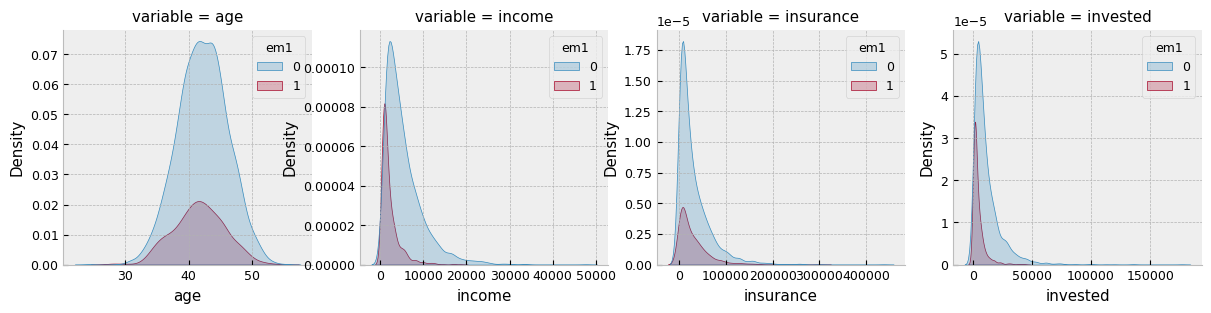

In [31]:
plt_df = pd.melt(email[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show()


### Stored Propensity Score

Now that we've confirmed that the assignment of `em1` is indeed biased, we can work on debiasing it with the propensity score. Now it's a good time to answer a question that might be in your head: why can't I just use orthogonalization? Or, more elegantly, when should I use the propensity score instead of orthogonalization. That's a good question and one I confess I don't have all the answers for. However, there is one clear case when there is a strong argument for the propensity score.

When you've stored the probabilities of receiving the treatment while conducting your experiment, **propensity score debiasing can be done without having to estimate a model**. If the assignment of the emails was done in a probabilistic way and we've stored those probabilities, then we don't have to rely on models. That's a huge advantage, because models are never perfect, which means that debiasing with them is also never perfect. Here, we have this situation where we've stored the probabilities of the treatments in the columns `em1_ps`, `em2_ps` and `em3_ps`.

Since we are dealing only with `em1`, we only need the probability in `em1_ps` to do the debiasing. Here is what we'll do. First, we will generate the debiasing weights by using the formula we've seen above. Then, we will resample with replacement from this dataset, using the newly created weights. This means a unit with weight 2 will be resampled twice as often as a unit with weight 1.

In [32]:
np.random.seed(123)
em1_rnd = email.assign(
    em1_w = email["em1"] / email["em1_ps"] + (1-email["em1"]) / (1-email["em1_ps"])
).sample(10000, replace=True, weights="em1_w")

In [33]:
np.random.seed(5)
em1_rnd.sample(5)

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,em1_w
2252,44.0,5102.43,42300.28,2294.60,0.097928,0.012976,0.902465,0,0,1,0,1.108559
4364,44.0,8503.72,751.08,33314.37,0.058805,0.188387,0.830375,1,0,0,1,17.005333
752,44.4,1778.21,24615.45,3054.08,0.279973,0.017270,0.972922,1,0,1,1,3.571777
3656,39.8,1752.18,487.22,1893.95,0.284108,0.010710,0.000000,0,0,0,0,1.396859
4613,43.1,1023.04,64695.01,2220.32,0.484638,0.012556,0.988928,0,0,1,1,1.940382


This resampling should make a new dataset that is debiased. It should have oversampled units that looked like the treated (high `em1_ps`) but did not get the treatment and those that looked like the control (low `em1_ps`), but got the treatment.

If we look at correlations between the treatment and the confounders, we can see that they essentially vanished.

In [34]:
em1_rnd[confounders + ["em1", "converted"]].corr()[["em1", "converted"]]

,em1,converted
age,-0.021004,0.404736
income,-0.026685,-0.037946
insurance,-0.037656,-0.071385
invested,-0.012073,-0.047987
em1,1.000000,0.076342
converted,0.076342,1.000000


Moreover, if we look at the confounders distributions by treatment assignment, we can see how nicely they align. This is not 100% proof that the debiasing worked, but it's good evidence of it.

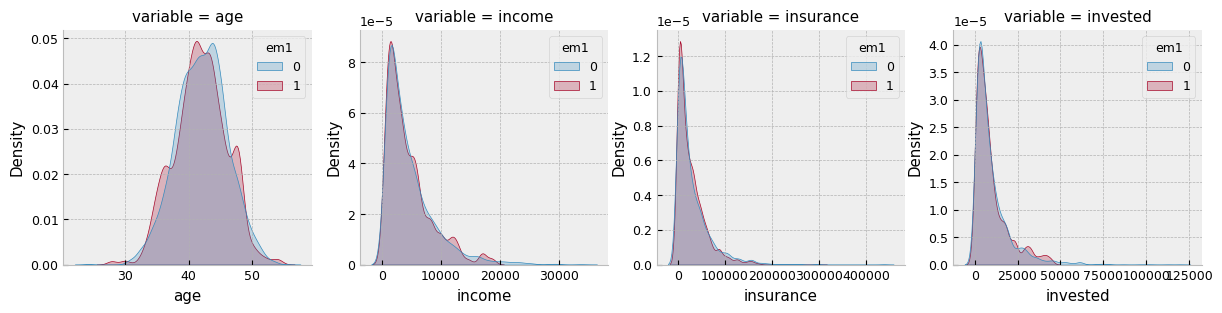

In [35]:
plt_df = pd.melt(em1_rnd[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show()

This new dataset we've created is now debiased. We can use it to do model evaluation or any other analys that requires the treatment to be randomly assigned. There is only one thing you need to watch out for. Notice how I've sampled 10000 points but the original dataset had only 5000? With this resampling method, I can make a debiased dataset as big as I wish. This means that confidence intervals that are computed in it are not valid, as they don't take into account the fact that the sample size can be artificially inflated.

Ok, so this technique was super effective because we had the stored probabilities in the first place, but what if we don't? What if we only have access to the confounders and the treatment that got assigned, but not to how likely those units were to get the treatment?

### Estimated Propensity Score

If we don't have the propensity score stored, we will have to estimate them. In this situation, it becomes less clear when you should use propensity score or orthogonalisation for debiasing.

Since we don't have the propensity score, we will use a machine learning model to estimate it. The propensity score is closely related to the probability of treatment, so this ML model must be calibrated to output a probability. Not only that, we need to do cross prediction to work around any sort of bias we might have due to overfitting.

In [40]:
t = "em1"

folds = 5

np.random.seed(123)

# makes calibrated Random Forest.
m_t = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, min_samples_leaf=40, max_depth=3),
    cv=3
)

# estimate PS with cross prediction.
ps_score_m1 = cross_val_predict(m_t, email[confounders], email[t],
                                 cv=folds, method="predict_proba")[:, 1]

In [41]:
email.assign(ps_score_m1_est = ps_score_m1).head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,ps_score_m1_est
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1,0.107973
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0,0.403693
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0,0.082788
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0,0.084226
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0,0.727700


Just out of curiosity, notice that the estimated propensity score, `ps_score_m1_est`, is close to the true one `em1_ps`, but not identical. Those errors in the estimation process will affect the final debiasing, but we hope it won't affect much. We can also check how well calibrated our score is. For that, we can plot the mean score against the mean `em1`. If the score is well calibrated, 20% of those with a score of 0.2 should have received email-1, 30% of those with a score of 0.3 should have received email-1 and so on.

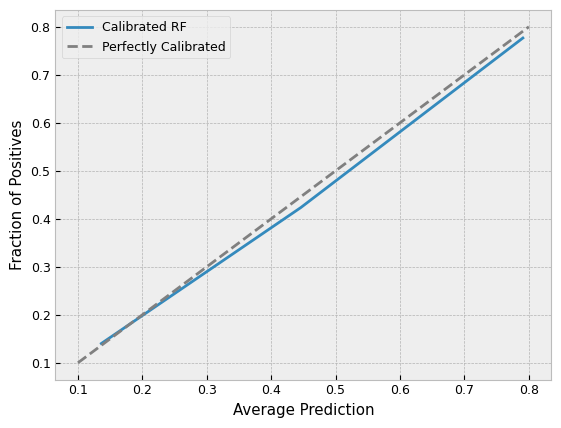

In [43]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(email["em1"], ps_score_m1, n_bins=3)
plt.plot(prob_pred, prob_true, label="Calibrated RF")
plt.plot([.1,.8], [.1, .8], color="grey", linestyle="dashed", label="Perfectly Calibrated")
plt.ylabel("Fraction of Positives")
plt.xlabel("Average Prediction")
plt.legend();

From here, we can proceed as if we had the true propensity score.


In [44]:
np.random.seed(123)
em1_rnd_est = email.assign(
    em1_w = email["em1"]/ps_score_m1 + (1-email["em1"])/(1-ps_score_m1)
).sample(10000, replace=True, weights="em1_w")

If we check the correlation structure, we will see that there are still some strong correlations between the treatment and the confounders, even after the debiasing process. For instance, income has a correlation of `-0.18` this is lower than the correlation in the unbiased dataset (`-0.3`), but much higher than what we got in the dataset that was debiased with the original propensity score (`0.01`). The same is true for the `invested` variable, which still shows some correlation.

In [46]:
em1_rnd_est[confounders + ["em1"]].corr()["em1"]

,em1
age,-0.025840
income,-0.151268
insurance,-0.036037
invested,-0.108351
em1,1.000000


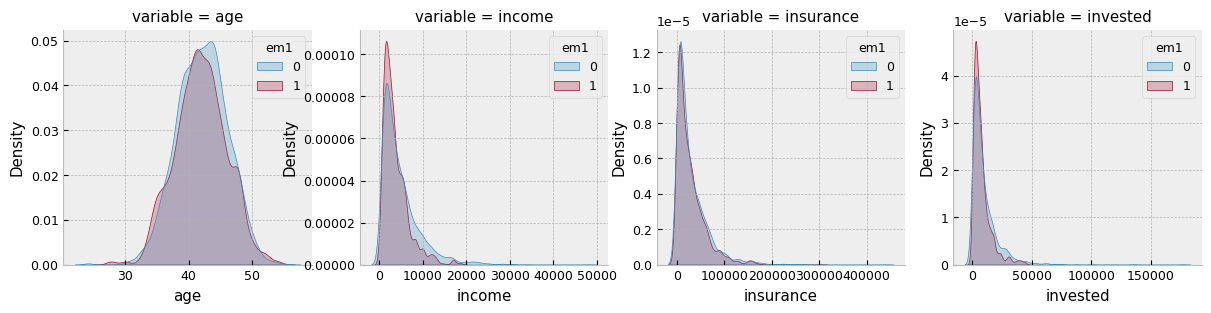

In [47]:
plt_df = pd.melt(em1_rnd_est[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show()

As for the distributions, we can see that they don't align that well as before, specially for the variables `invested` and `income`

## The Weakness of Propensity Score

We've already talked a lot about this on the propensity score chapter, so I won't spend much time on it, but it is recalling one of the main weaknesses with the propensity score debiasing. It has to do with propensities scores that are two high or too low.


To understand this, take a look at the following unit in our original dataset.

In [48]:
email.loc[[1014]]

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
1014,43.2,18628.09,30356.68,28335.68,0.026862,0.160233,0.615788,1,0,0,1


This unit has a propensity score of 0.027 for `em1`. This means it's weight will be around 37 (1/0.027). This unit will be sampled almost twice as much as a treated unit with a propensity score of 0.05 (weight of 20), which is already a very low propensity score. This unit appears 38 times in the dataset we've resampled using the stored (not estimated) propensity score.

In [49]:
em1_rnd.loc[[1014]].shape

(38, 12)

That's a problem, because the debiased dataset is overpopulated with only one unit. If this unit wasn't in the original dataset, the debiased dataset could look totally different. So, removing a single unit can affect a lot how a debiased dataset looks like. This is a problem of high variance.

If we plot the number of replications for each unit in the debiased dataset, we see that a bunch of them appear more than 10 times. Those are treated units with low propensity score or untreated units with high propensity score.

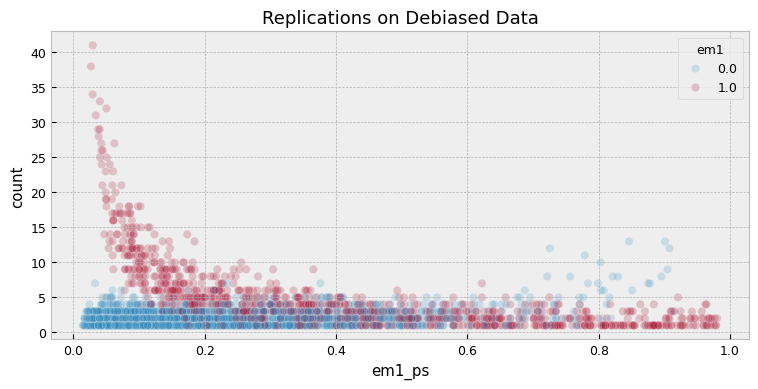

In [51]:
plt.figure(figsize=(9, 4))
sns.scatterplot(
    data = em1_rnd.assign(count=1).groupby(em1_rnd.index).agg(
        {"count":"count", "em1_ps":"mean", "em1":"mean"}),
    x="em1_ps",
    y="count",
    hue="em1",
    alpha=0.2
)
plt.title("Replications on Debiased Data");

To avoid having overly important units, some scientists like to clip the weights, forcing them to be, let's say, at most 20. It is true that this technique will remove some of the variance, but it will add bias back. Since the whole point of this was to remove bias, I feel like clipping the weights is not a good idea.

In my opinion, the best thing you can do is at the experimentation phase, not at the analysis phase. You should make sure none of the units have a weight that is too high. In other words, as much as possible, try to give the treatment with equal probabilities to everyone.

To be fair to the propensity weighting method, all causal inference methods will suffer whenever the probability of receiving either the treatment or the control is too low, for the entire sample or for a subpopulation. Intuitively, this means some units will almost never receive the treatment or the control, which will make it difficult to estimate counterfactuals for those units. This problem can be seen as almost violating the common support assumption, which we will explore next.

## Positivity or Common Support

Besides high variance, we can also have problems with positivity. Positivity, or common support is a causal inference assumption which states that there must be sufficient overlap between the characteristics of the treated and the control units. Or, in other words, that everyone has a non zero probability of getting the treatment or the control. If this doesn't happen, we won't be able to estimate a causal effect that is valid for the entire population, only for those we have common support.

To be clear, positivity issues are problems of the data itself, not a problem with the propensity score method. Propensity score method just makes it very clear when positivity problems exist. In that sense, this is an argument in favor of the propensity score. While most methods will not warn you when there are positivity problems, propensity score will show it to your face. All you have to do is plot the distribution of the propensity score for the treated and for the untreated.

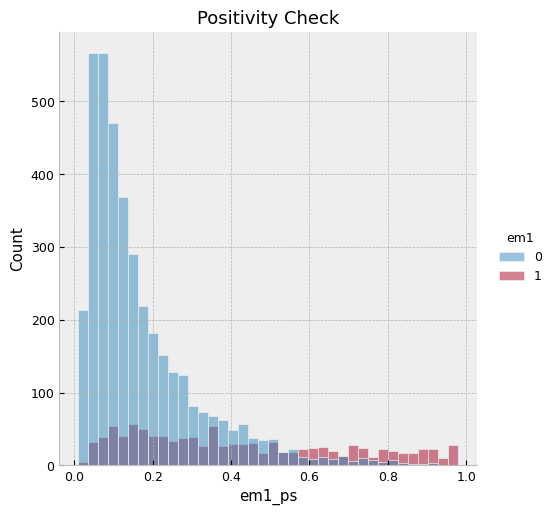

In [53]:
sns.displot(data=email, x="em1_ps", hue="em1")
plt.title("Positivity Check");

If they have a nice overlap, like in the plot above, then you have common support.

Up until now, we've only looked at email-1 (`em1`). Let's look at email-3 now.

In [54]:
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


First thing that jumps the eye is that there are units with zero probability, which already indicates a violation to the positivity assumption. Now, let's look at the features distributions by `em3`

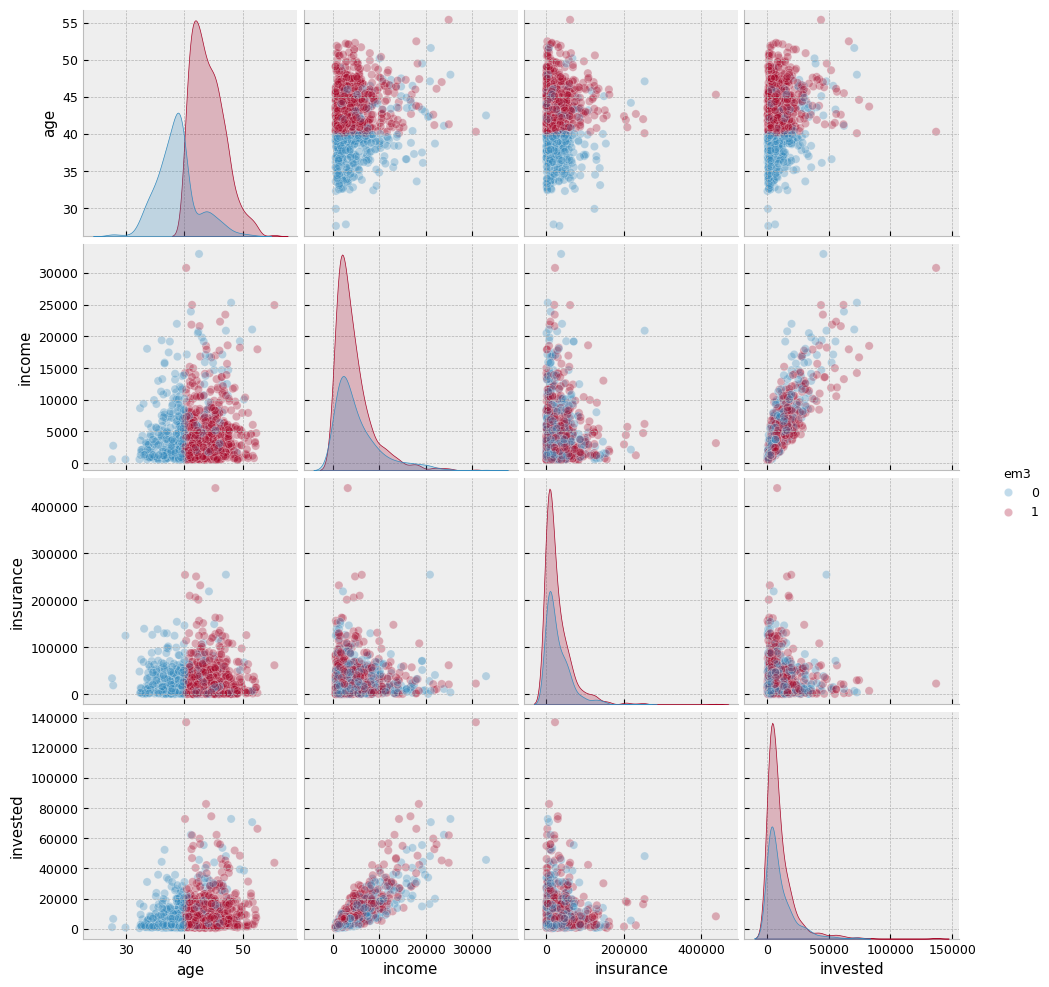

In [55]:
sns.pairplot(email.sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3));

It looks like `em3` was only sent to customers that are older than 40 years. Thats a huge problem. If the control has younger folks, but the treatment doesn't, there is no way we can estimate the counterfactual $Y_0|T=1, age<40$. Simply because we have no idea how younger customers will respond to this email.

Just so you know what will happen, we can try to make the propensity score debiasing.

In [56]:
em3_weight = (email
              # using a different implementation to avoid division by zero
              .assign(em3_w = np.where(email["em3"].astype(bool), 1/email["em3_ps"], 1/(1-email["em3_ps"])))
              .sample(10000, replace=True, weights="em3_w"))

In [57]:
em3_weight[confounders + ["em3"]].corr()["em3"]

,em3
age,0.251035
income,0.047607
insurance,-0.000961
invested,0.053524
em3,1.000000


As we can see, there is still a huge correlation between age and the treatment. Not having treated samples that are younger than 40 years made it so that we couldn't remove the bias due to age.

We can also run the positivity diagnostic, plotting the propensity score distribution by treatment.

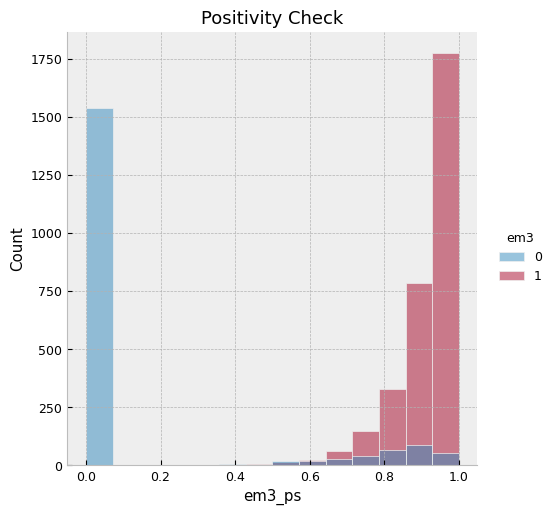

In [58]:
sns.displot(data=email, x="em3_ps", hue="em3")
plt.title("Positivity Check");

Notice how poor the overlap is here. Units with propensity score below 0.4 almost never get the treatment. Not to mention that huge peak at zero.

### Positivity In Practice

Issues in positivity are very serious in the academic world because they treat the generalization of a conclusion or theory. If you only have treated individuals that are older, you have no way of generalizing whatever treatment effect that you find to a younger population. But in the industry, violations of the positivity assumption might not be so problematic.

To give an example, if you are a lender wishing to estimate the elasticity of loan amount on probability of default, you will probably not give high loans to people with very low credit scores. Sure, this will violate the positivity assumption, but you are not very interested in estimating the loan amount elasticity for risky customers because you are not intending to give them loans anyway. Or, for a somewhat more exaggerated example, if you want to estimate the price elasticity of some product, you will probably not test prices from 0 to 1000000. That's because you have some intuition on where the prices normally are. You will often test around that region.

The point here is that you can (and probably should) use your intuition to exclude some part of the population from receiving the treatment (or the control). Doing random experiments is expensive, so you should focus your efforts on where things are more promising.

In our email example, probably the marketing team though that email-3 should never be sent to younger people. Maybe it contains text explicitly discussing something that only older people can relate to. Regardless of the reason, we can only estimate the effect of email-3 on the older, age>40, population. And that is totally fine. We just shouldn't expect to generalize whatever findings we have to the younger population.

With that in mind, let's debias email-3. Of course, we will remove the younger population from the sample.

In [59]:
em3_weight.query("age>40")[confounders + ["em3"]].corr()["em3"]

,em3
age,-0.034455
income,0.024633
insurance,-0.005650
invested,0.020711
em3,1.000000


Once we do that, notice how the correlation between the treatment and the confounders goes away. Remember that in the entire sample, the correlation with age was more than 0.2. Now, it is probably indistinguishable from zero.

We can also explore the distribution of treated and non treated in this filtered sample.

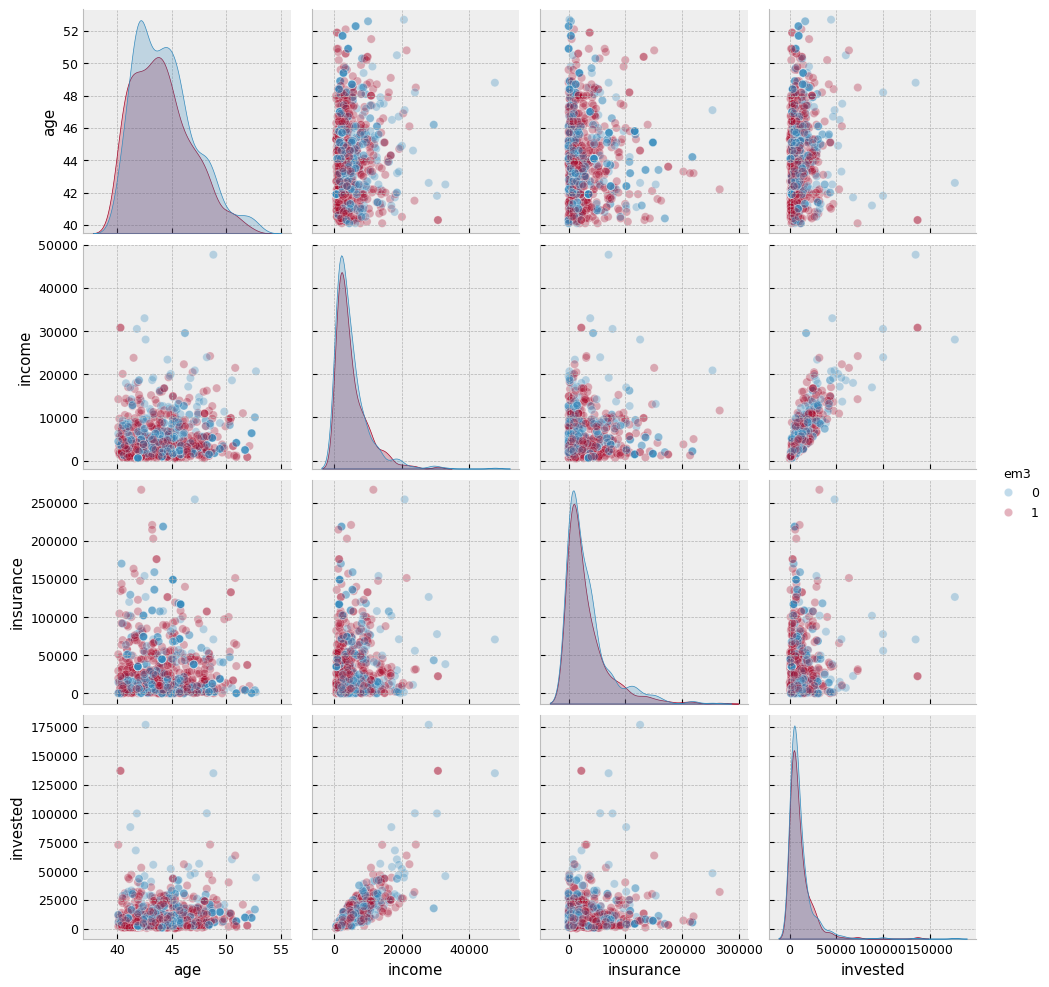

In [61]:
sns.pairplot(em3_weight.query("age>40").sample(1000)[confounders + ["em3"]], hue="em3",
             plot_kws=dict(alpha=0.3));

All of this to say that, yes, due to positivity violations, you can't debias the entire sample with respect to `em3`. But you can do it for the population for which email-3 was designed for in the first place. That is good enough.

## Key Ideas

This chapter presented another debiasing idea for when the treatment is binary or discrete. The idea is to resample the units using the inverse propensity score as a weight. This will upsample the units that look like the treated (high propensity score) but where not treated and those that look like the untreated (low propensity score) but where treated.

The main advantage of propensity score debiasing is that it doesn't require estimating a model, if you've stored the probabilities of treatment during the experiment. This doesn't mean you can't apply propensity reweighting if you don't have those probabilities, but having to estimate them will add additional error to your debiasing process.

As for the disadvantages, the propensity score reweighting can have a huge variance if the propensity score is either too high or too low, generating huge weights. Intuitively, this happens when there are very few untreated units that look like the treated and very few treated units that look like the untreated. To be fair to the propensity score weighting, this is a problem for all causal inference methods, but propensity weighting highlights this almost violation to the positivity assumption more clearly.

Finally, we had a brief discussion about how much of a problem is violation in the positivity assumption. We ended up concluding that it is not a problem **as long as you don't wish to generalize your conclusions to the subset of the population where positivity doesn't hold**.